In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_image(image_path, max_size=400):
    image = Image.open(image_path).convert('RGB')

    size = max(image.size)
    if size > max_size:
        size = max_size

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])

    image = transform(image).unsqueeze(0)
    return image.to(device)


In [3]:
from google.colab import files
uploaded = files.upload()


Saving content.jpg to content.jpg
Saving style.jpg to style.jpg


In [4]:
content = load_image("content.jpg")
style = load_image("style.jpg")


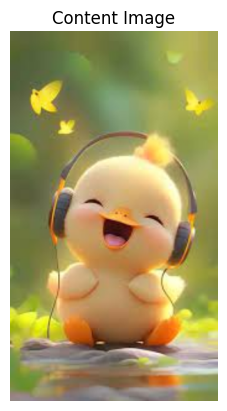

In [5]:
def show_image(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")

show_image(content, "Content Image")

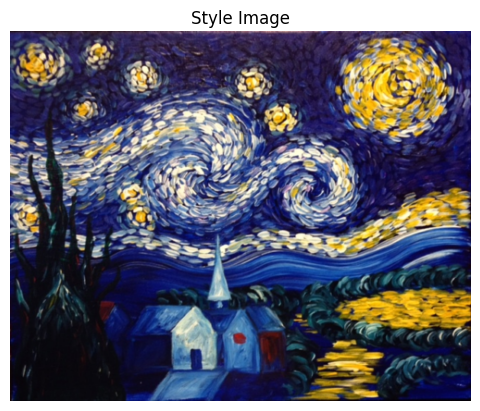

In [6]:
def show_image(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")
show_image(style, "Style Image")

In [7]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:07<00:00, 74.7MB/s]


In [8]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [9]:
content_layer = '21'
style_layers = ['0', '5', '10', '19', '28']


In [10]:
def get_features(image, model):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in style_layers:
            features[name] = x
        if name == content_layer:
            features[name] = x
    return features


In [11]:
target = content.clone().requires_grad_(True).to(device)


In [12]:
import matplotlib.pyplot as plt

def show_image(tensor, title=None):
    image = tensor.detach().cpu().squeeze(0)
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")


In [13]:
optimizer = optim.Adam([target], lr=0.003)

style_weight = 1e6
content_weight = 1

for step in range(300):
    target_features = get_features(target, vgg)
    content_features = get_features(content, vgg)
    style_features = get_features(style, vgg)

    content_loss = torch.mean(
        (target_features[content_layer] - content_features[content_layer])**2
    )

    style_loss = 0
    for layer in style_layers:
        target_gram = gram_matrix(target_features[layer])
        style_gram = gram_matrix(style_features[layer])
        style_loss += torch.mean((target_gram - style_gram)**2)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, Loss: {total_loss.item():.2f}")


Step 0, Loss: 247789531430912.00
Step 50, Loss: 41762974334976.00
Step 100, Loss: 25670105169920.00
Step 150, Loss: 19682312585216.00
Step 200, Loss: 16013390249984.00
Step 250, Loss: 13329964728320.00


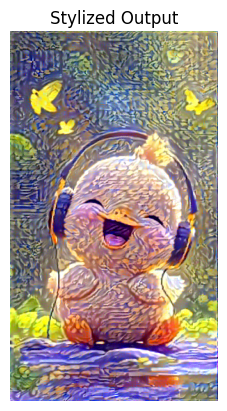

In [14]:
show_image(target, "Stylized Output")
